In this workbook, we are going to build a model that interprets unknown temperature units into celcius. To do this, the model will adjust the weights of the model iteratively until a measure of error is low enough.

In [39]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [40]:
# THE DATA

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # temps in celcius

t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # temps in unknown unit

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'celcius')

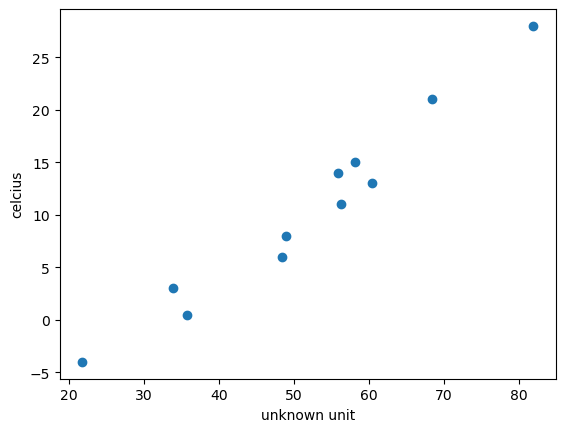

In [41]:
# plotting the data - looks like a linear relationship!
fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
ax.set_xlabel('unknown unit')
ax.set_ylabel('celcius')

### Linear Relationships
Since we can see there is a linear relationship between the two data sets, we can map out a linear relationship:
$$celcius~=~w\times unknown~unit + b$$
We can stick to the terms *weight* and *bias* for *w* and *b*. These are the *parameters* in our model.

In [42]:
#writing our model as a function
def model(unknown_unit, w, b):
    return w * unknown_unit + b

## Loss Function
A *loss function* is a function that computes a single numerical value that the learning process will attempt to minimize. We need to ensure that the loss function returns a positive value for $predicted > actual$ and $predicted < actual$. For this we will use:
$$ (predicted - actual)^2$$
Since we are working with tensors, we will take the *mean square loss*. In other words, we subtract the tensors, then take their square *element wise* and then average the loss of all elements in the tensor.

In [43]:
#writing our mean-squared loss function
def loss_fn(predicted, actual):
    squared_diffs = (predicted - actual)**2
    return squared_diffs.mean()

### First forward pass

In [44]:
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [45]:
t_predicted = model(t_u, w, b)
t_predicted

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [46]:
# check the value of the loss
loss = loss_fn(t_predicted, t_c)
loss

tensor(1763.8848)

## Gradient Descent
The gradient descent algorithm computes the rate of change of the loss with respect to each parameter, and modifies each parameter in the direction of decreasing loss.

### Decreasing Loss - A crude way!
The below helps provide an intuition of how gradient descent works, but is not actually how it is implemented.

In [53]:
delta = 0.1 # the 'momentum' at which the algorithm will move

# the loss rate of change in respect to the parameter w
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w



tensor(4517.2974)

The above is measuring the loss difference between moving the parameter *w* one *delta* unit forward. In this case, the loss increases, meaning we need to decrease *w* to decrease the loss. <br><br>
We want to take this information and reassign a value to the parameter *w*. Since we want to decrease the variable *w* when we have a positive *loss rate of change*, we subtract the above from *w* to decrease *w*. This works both ways; if the *loss rate of change is negative*, then subtracting it from *w* will lead to an increase of *w*'s value.<br><br>
However, we also want to ensure we don't overshoot the optimal value for *w*. To ensure that we don't, we scale the *loss rate of change* by a factor that is called the ***learning rate***.

In [54]:
learning_rate = 1e-2

#updating the value of w
w = w - learning_rate * loss_rate_of_change_w

We do the same with the bias *b*.

In [55]:
# calculate the loss rate of change in respect to b
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

#update b based on the loss rate of change scaled by a learning rate
b = b - learning_rate * loss_rate_of_change_b


### Derivatives
For example, our loss function incorporates the below function. For sake of example, let's assume this is our entire loss function:
$$ (predicted - actual)^2$$
Which is plotted like this:<br><br>
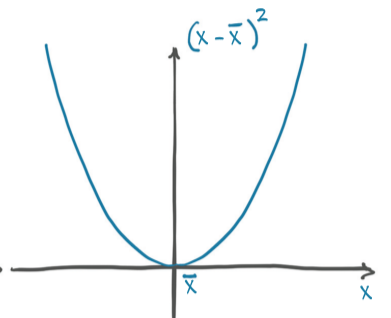

You could measure the *rate of change* between two x values in the above function. For example, given two x values, you can calculate the change in y over the change in x to get the slope. This rate of change is what we were calculating in the 'crude decreasing loss' section above. To find the minumum loss, if the *loss rate of change* (slope) is positive, we need to decrease the value of ouor variable, and if the *loss rate of change* (slope) is negative, we need to increase the value of our variable. <br><br> 
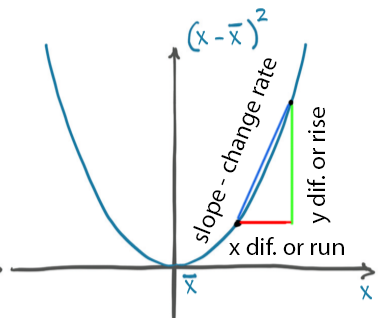


If you were to shrink that rise over run to an infintely small ratio, you could still determine a slope. This is the ***derivative***. It's also the tangent to the curve at a given point.<br><br>
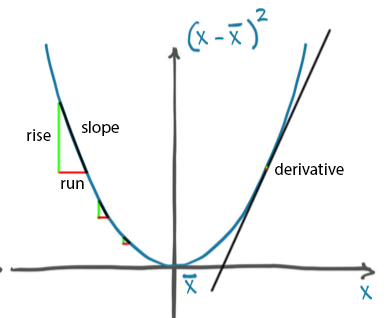
<br><br>
This is something I need to brush up on MUCH MORE, but the 20,000 ft. view is that you can combine derivatives (many of which are given in [handy tables](https://mathcentre.ac.uk/resources/Engineering%20maths%20first%20aid%20kit/latexsource%20and%20diagrams/8_2.pdf) ) using the *chain rule*. You can also solve for *partial derivatives* in respect for a certain variable in a function. All this being said, I need to study a lot more, but for right now, I know that given a loss function, you can find out whether you need to increase of decrease the given parameters (like *w* and *b*) to minimize the loss using derivatives (or more accurately *gradients*). You can do this for setting all parameters but one to be constants, and solve the *partial derivative* for said parameter.


### Gradients and Stochastic Gradient Descent
The derivative of a tensor operation is called a *gradient*. This is why our optimizer is called *stochastic gradient descent*. We are picking our initial parameters at random, then doing a forward pass, calculating our loss, and then doing a backwards pass by taking the gradient of our forward pass, and using the this information to tweak our parameters by a factor of our *learning rate* in the direction prescribed by the gradient.<br><br>
In reality, it's impossible to visualize this for a many-dimensioned tensor, but you can sort of visualize this process as finding the lowest point in a terrain.<br><br>
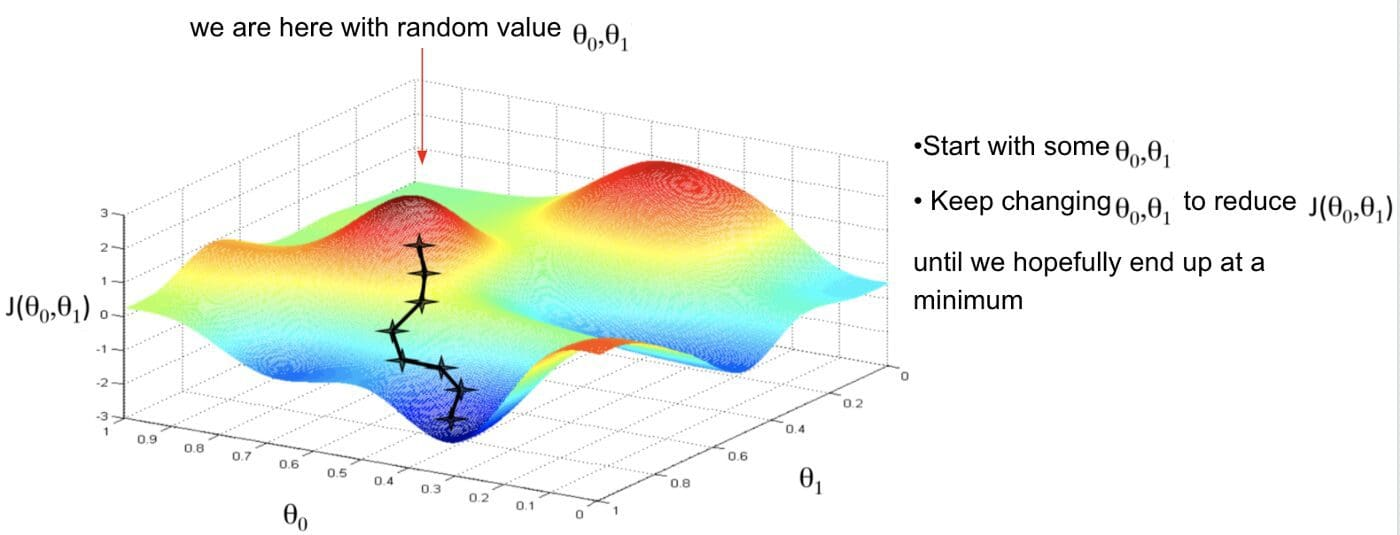

---
Back to following along with the book...

In [56]:
# taking the derivative of the loss function
def d_loss(predicted, actual):
    dsq_diffs = 2 * (predicted - actual) / predicted.size(0) #division is from derivative of mean
    return dsq_diffs

#derivative of model in respect to w
def d_model_w(unknown_unit, w, b):
    return unknown_unit

#derivative of model in respect to b
def d_model_b(unknown_unit, w, b):
    return 1.0

# returning the gradient of the loss with respect to w and b
def grad_fn(unknown_unit, actual, predicted, w, b):
    d_loss_unknown_actual = d_loss(predicted, actual)
    d_loss_w = d_loss_unknown_actual * d_model_w(unknown_unit, w, b)
    d_loss_b = d_loss_unknown_actual * d_model_b(unknown_unit, w, b)
    return torch.stack([d_loss_w.sum(), d_loss_b.sum()])

### The Training Loop
A training iteration during which we update the parameters for all of our training samples is called an *epoch*. For this first run, we will just run for a predefined number of epochs.


In [57]:
def training_loop(num_epochs, learning_rate, params, unknown_unit, celcius):
    for epoch in range(1, num_epochs + 1):
        w, b = params

        prediction = model(unknown_unit, w, b) # forward pass
        loss = loss_fn(prediction, celcius) # calculate loss
        gradient = grad_fn(unknown_unit, celcius, prediction, w, b) # backward pass

        params = params - learning_rate * gradient # updating the parameters

        print(f'Epoch {epoch}, Loss {loss}')
    
    return params

In [59]:
# invoking the training loop
init_params = torch.tensor([1.0, 0.0]) # initial values of w and b

training_loop(num_epochs=100, learning_rate=1e-2, params=init_params, unknown_unit=t_u, celcius=t_c)

Epoch 1, Loss 1763.884765625
Epoch 2, Loss 5802484.5
Epoch 3, Loss 19408029696.0
Epoch 4, Loss 64915905708032.0
Epoch 5, Loss 2.1713052546105344e+17
Epoch 6, Loss 7.262575831529281e+20
Epoch 7, Loss 2.429183416467663e+24
Epoch 8, Loss 8.125122549611731e+27
Epoch 9, Loss 2.717688212084259e+31
Epoch 10, Loss 9.090110518901907e+34
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss nan
Epoch 42, Loss nan
Epoch 43, Loss nan
Epoch 44, Loss nan
Epoch 45, Loss nan
Epoch

tensor([nan, nan])

We can see from the above that our loss went to INFINITE! This is due to our `learning_rate` being too large and our model overshooting the target. Let's try again.

In [60]:
# invoking the training loop with a smaller learning_rate
init_params = torch.tensor([1.0, 0.0]) # initial values of w and b

training_loop(num_epochs=100, learning_rate=1e-4, params=init_params, unknown_unit=t_u, celcius=t_c)

Epoch 1, Loss 1763.884765625
Epoch 2, Loss 323.09051513671875
Epoch 3, Loss 78.92963409423828
Epoch 4, Loss 37.5528450012207
Epoch 5, Loss 30.540283203125
Epoch 6, Loss 29.351154327392578
Epoch 7, Loss 29.148883819580078
Epoch 8, Loss 29.113847732543945
Epoch 9, Loss 29.107145309448242
Epoch 10, Loss 29.105247497558594
Epoch 11, Loss 29.104167938232422
Epoch 12, Loss 29.103221893310547
Epoch 13, Loss 29.102294921875
Epoch 14, Loss 29.10137939453125
Epoch 15, Loss 29.100465774536133
Epoch 16, Loss 29.09954833984375
Epoch 17, Loss 29.098630905151367
Epoch 18, Loss 29.09771728515625
Epoch 19, Loss 29.0967960357666
Epoch 20, Loss 29.09588050842285
Epoch 21, Loss 29.094959259033203
Epoch 22, Loss 29.09404945373535
Epoch 23, Loss 29.0931339263916
Epoch 24, Loss 29.09221649169922
Epoch 25, Loss 29.09130096435547
Epoch 26, Loss 29.09038543701172
Epoch 27, Loss 29.08946418762207
Epoch 28, Loss 29.088550567626953
Epoch 29, Loss 29.087635040283203
Epoch 30, Loss 29.086713790893555
Epoch 31, Loss 

tensor([ 0.2327, -0.0438])

The above behaviour is now stable, and we are converging towards a minimum loss. However, the updates to the parameters are very small so loss decreases slowly and eventually stalls. We can make some changes to our model to correct this.<br><br> 
### Normalizing Inputs
The learning rate will affect the parameters *w* and *b* differently since both are at much different scales. Assuming *w* is much larger than *b*, a tiny learning rate will work well for *b* but won't affect *w* much, whereas a large learning rate will affect *w* properly but will be unstable with *b*.<br><br>
To compensate for this, we can normalize the inputs so that all variables range from roughly -1.0 to 1.0. In this case, we can just multiply the unknown temperatures by 0.1.